In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter,MultipleLocator

In [22]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [23]:
path = r"../data/skills"
df_raw = load_df(path, skip_rows=0)

In [24]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [25]:
def clean_skills_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [str(c).strip() for c in out.columns]

    if "AvgSkillChangePct" in out.columns:
        pct = (out["AvgSkillChangePct"].astype(str)
                                   .str.strip()
                                   .str.replace("%", "", regex=False))
        out["AvgSkillChangePct"] = pd.to_numeric(pct, errors="coerce")

    for col in ("Industry", "TopSkills2015", "TopSkills2022"):
        if col in out.columns:
            out[col] = out[col].astype(str).str.strip()
    return out



In [62]:
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

def plot_diverging_bar_from_df(
    df_clean: pd.DataFrame,
    title="Change in Skills Demand by Industry",
    out_basename="chart7_diverging_bar",
    chart_dir="chart-7",
    figsize=None,
    bar_color="#45A3FAF9",   # light blue
    edge_color="#2c3e50",
    label_fmt="{:+.0f}%",
    x_major_step=10,         # major ticks every 5%
    x_minor_step=2,         # minor ticks every 2%
):
    # Aggregate (mean) and sort
    agg = (df_clean.groupby("Industry", as_index=False)["AvgSkillChangePct"]
                   .mean()
                   .dropna(subset=["AvgSkillChangePct"])
                   .sort_values("AvgSkillChangePct", ascending=True))

    # Auto size
    if figsize is None:
        h = max(6, min(14, 0.35 * len(agg)))
        figsize = (12, h)

    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    ax.set_facecolor("#f8f9fb")

    y = np.arange(len(agg))
    vals = agg["AvgSkillChangePct"].values
    industries = agg["Industry"].values

    bars = ax.barh(
        y, vals,
        color=bar_color,
        edgecolor=edge_color,
        linewidth=0.6,
        zorder=3
    )

    # Zero line
    ax.axvline(0, color="#888", linewidth=1, alpha=0.7, zorder=2)

    # Grid: major & minor on x
    ax.grid(True, which="major", axis="x", linestyle="--", alpha=0.6, zorder=1)
    ax.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.25, zorder=1)
    ax.grid(False, axis="y")

    # Tick locators: minor every 2%, major every 5% (configurable)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_step))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor_step))

    # Labels / titles
    ax.set_yticks(y)
    ax.set_yticklabels(industries)
    ax.set_xlabel("Average change in skills demand (%)", labelpad=10)
    ax.set_title(title, fontweight="bold", pad=12)

    # Clean spines
    for spine in ("top", "right", "left"):
        ax.spines[spine].set_visible(False)

    # End labels
    xmax = np.nanmax(np.abs(vals)) if len(vals) else 1
    xpad = xmax * 0.02 + 0.5
    for b, v in zip(bars, vals):
        if np.isnan(v): 
            continue
        x = b.get_width()
        sign = 1 if x >= 0 else -1
        ax.text(
            x + sign * xpad, b.get_y() + b.get_height()/2,
            label_fmt.format(v),
            va="center",
            ha="left" if x >= 0 else "right",
            fontsize=9,
            color="#12232e"
        )

    # Formatting & limits
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(0, xmax*1.15)



    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


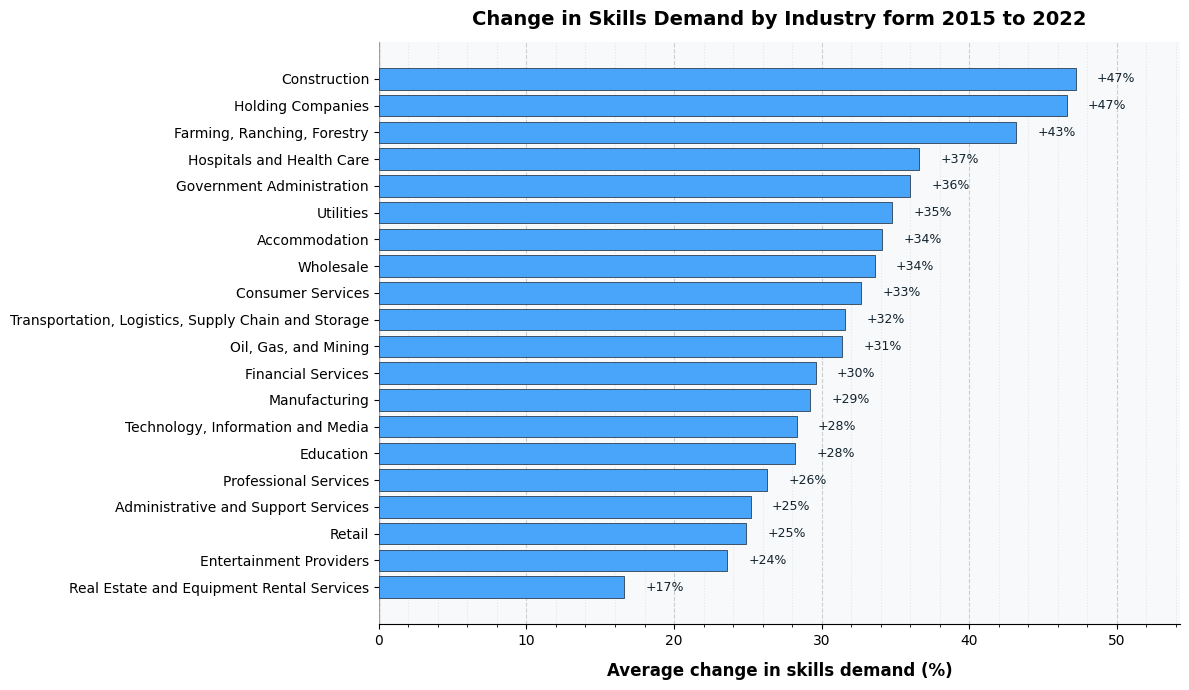

In [63]:
df_clean = clean_skills_df(df_raw)

plot_diverging_bar_from_df(
    df_clean,
    title="Change in Skills Demand by Industry form 2015 to 2022",
    out_basename="skills_diverging",
    chart_dir="chart-7"
)
